<ipython-input-3-bcf97a7b6ed1>:21: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['HORA_REAL'] = pd.to_datetime(df['HORA_INICIAL_REAL'], errors='coerce')


Las horas pico identificadas son: [5, 6, 7, 8]

Top 10 vehículos con más despachos en horas pico:
    FK_VEHICULO  num_despachos
34           47            617
39           52            548
48           63            510
38           51            493
10           16            482
5             8            478
31           44            474
29           42            464
52           69            450
46           61            450

Coeficiente de variación general en la distribución de despachos: 0.4698
Un valor más cercano a 0 indica una distribución más equitativa.


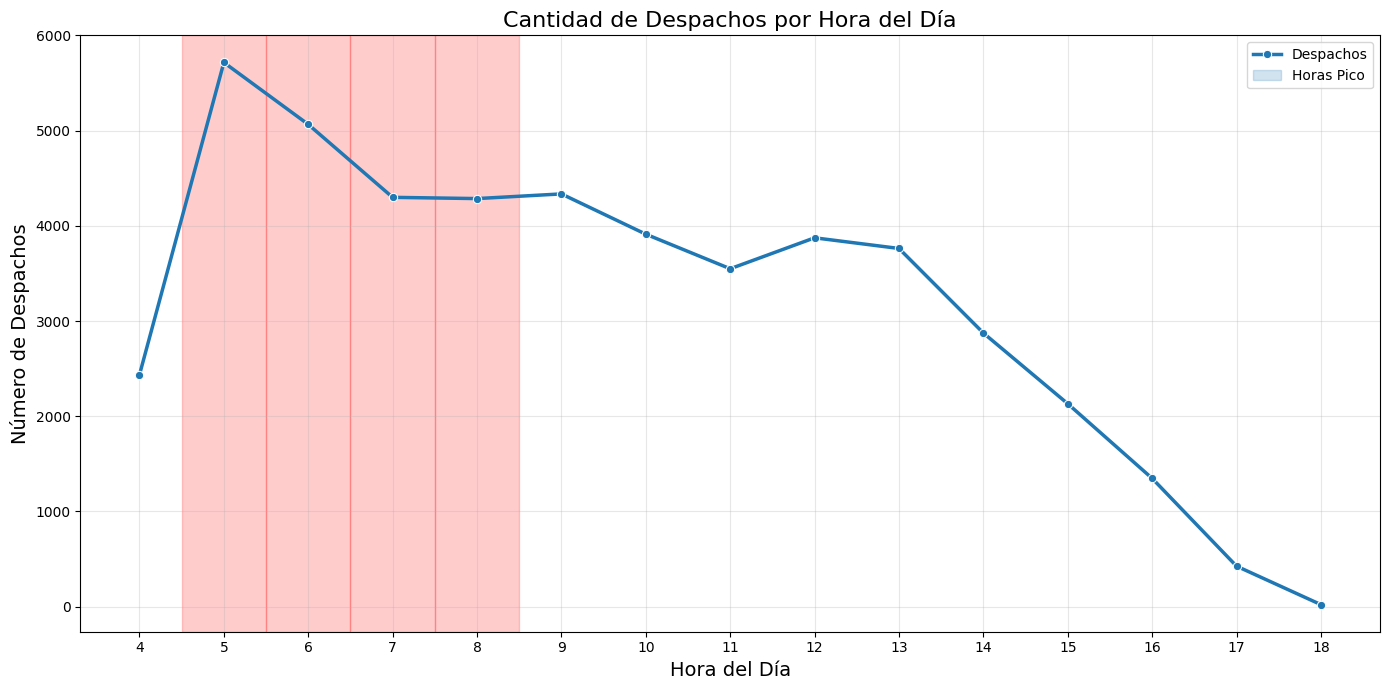

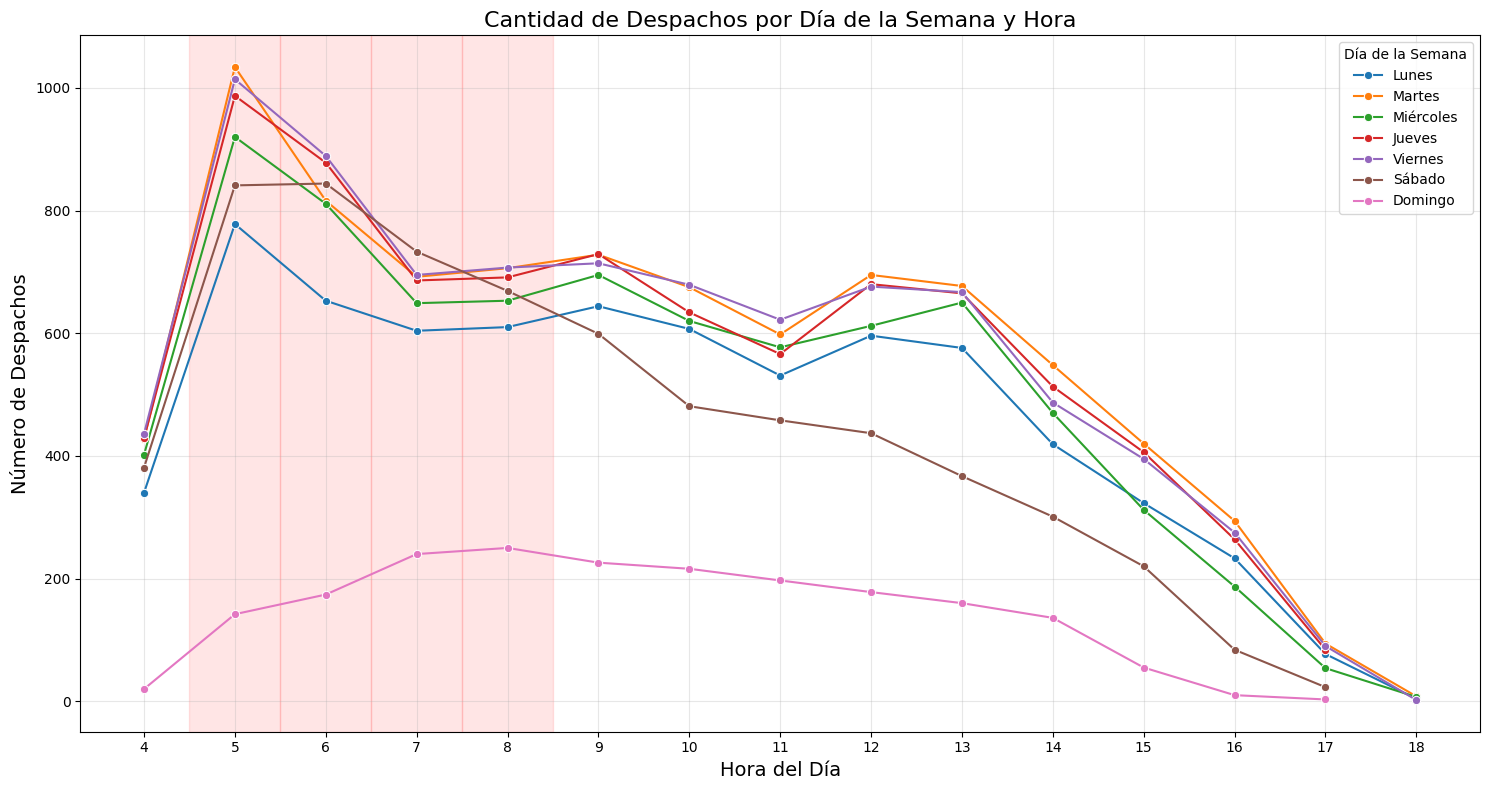

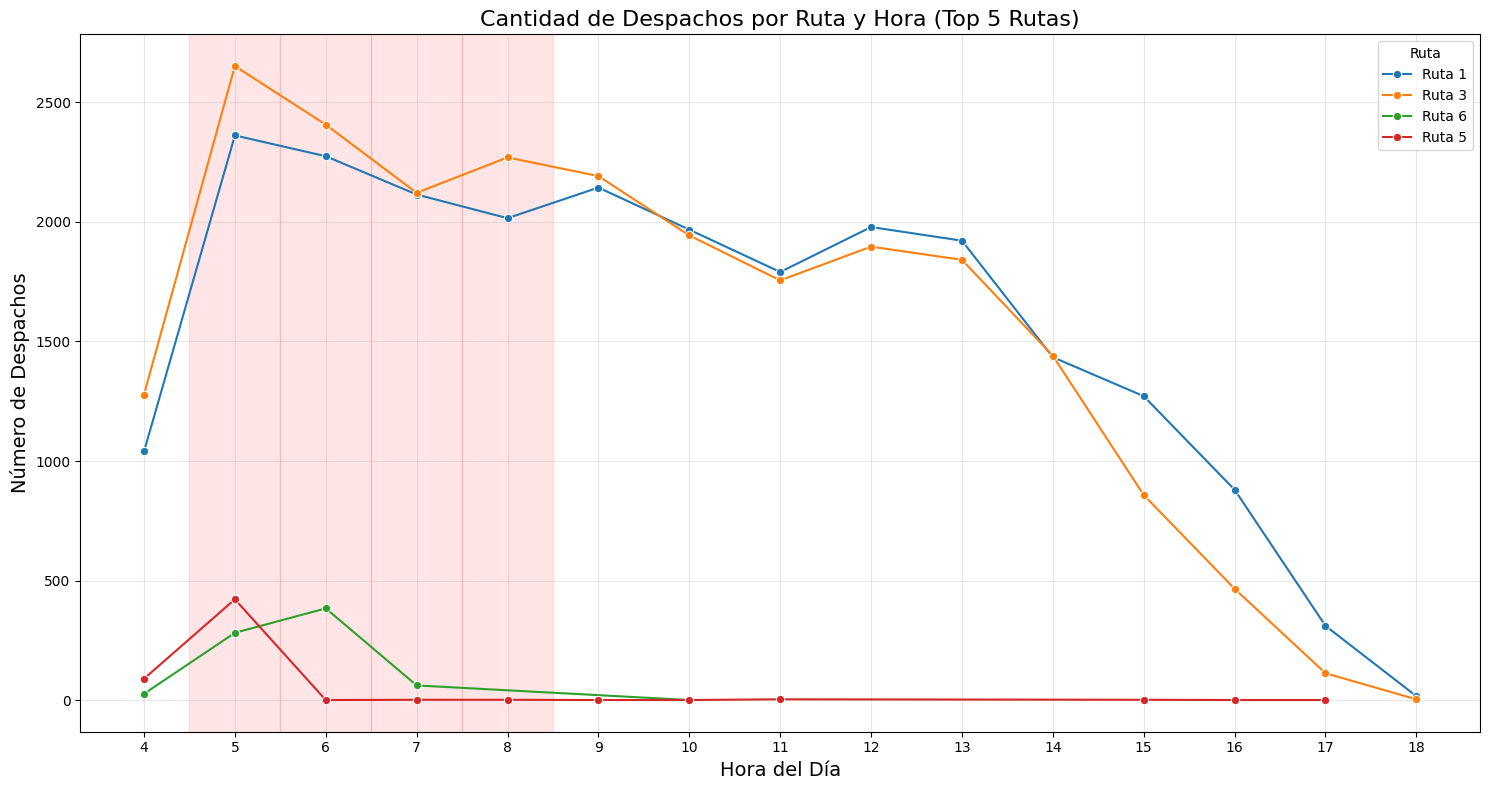

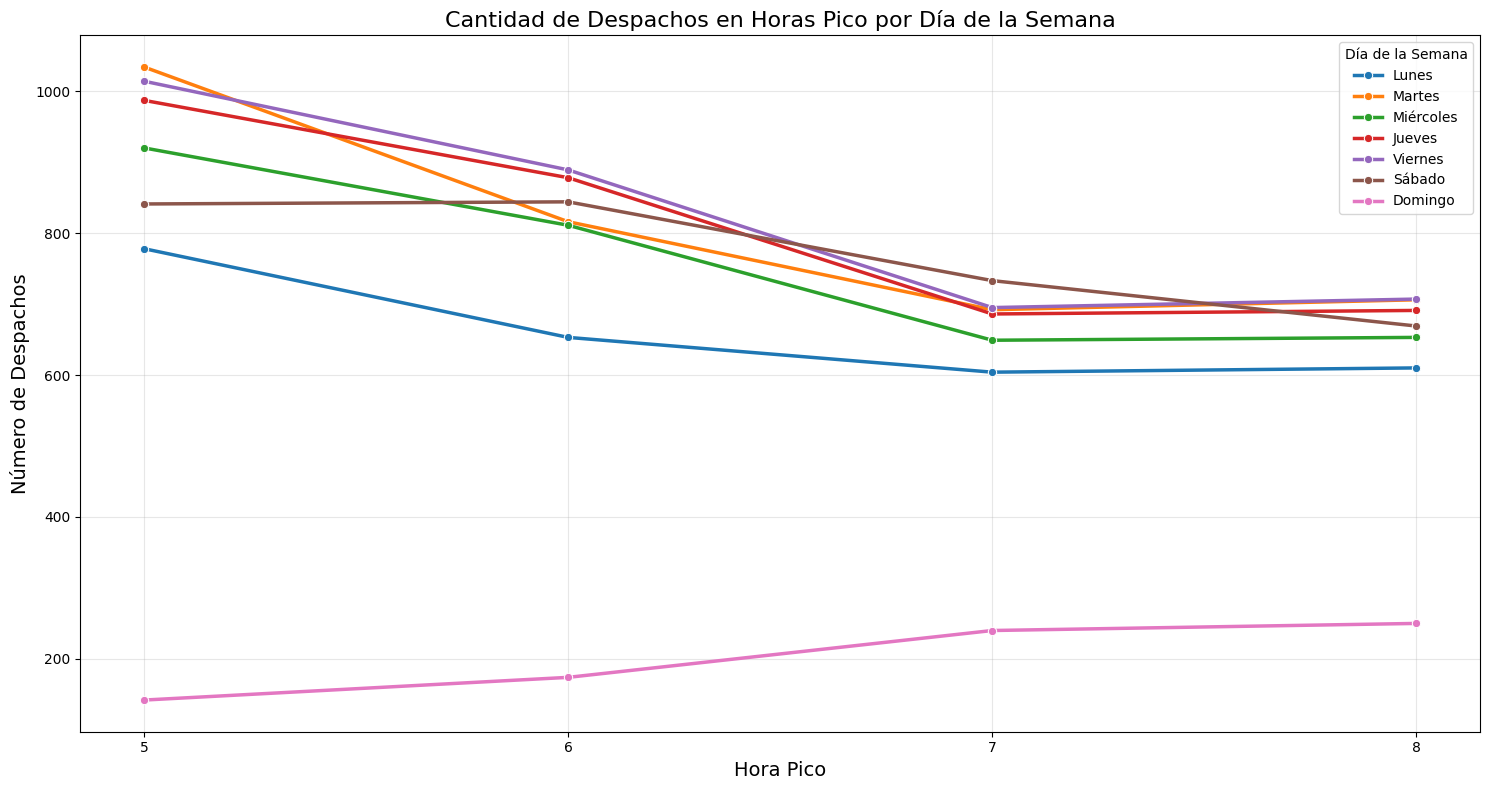

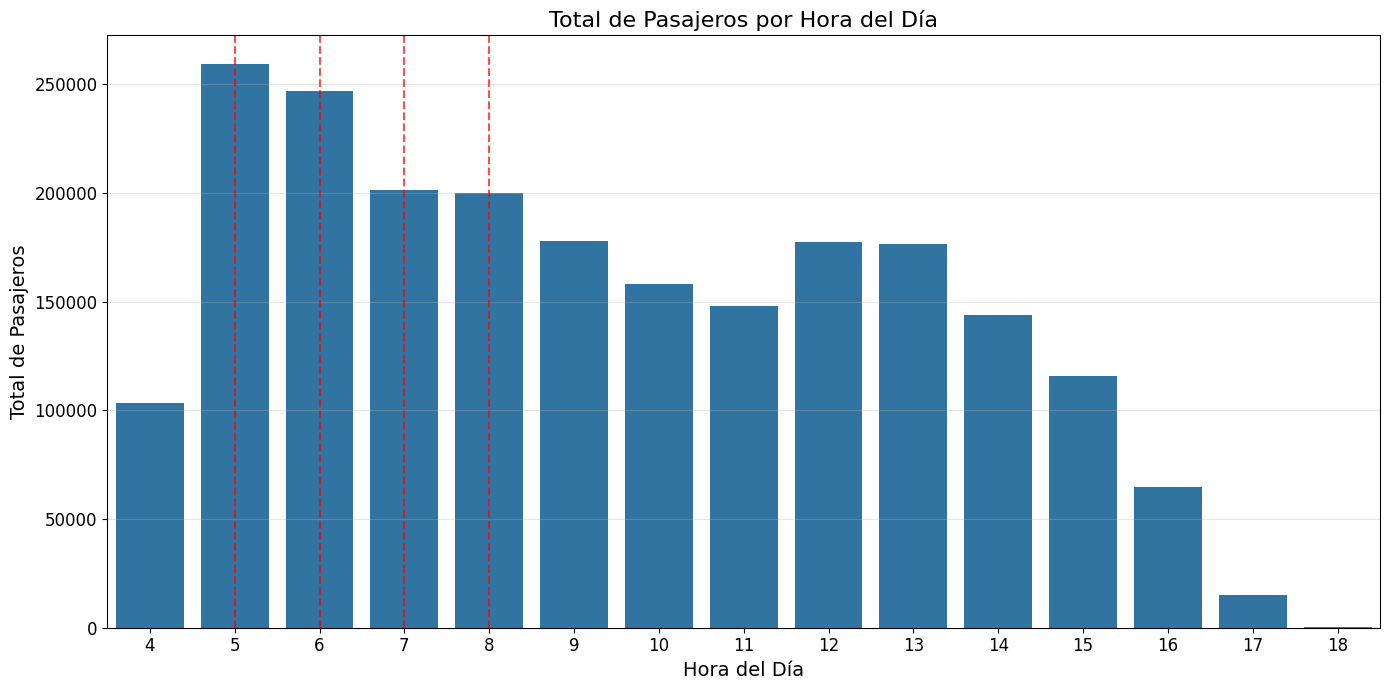

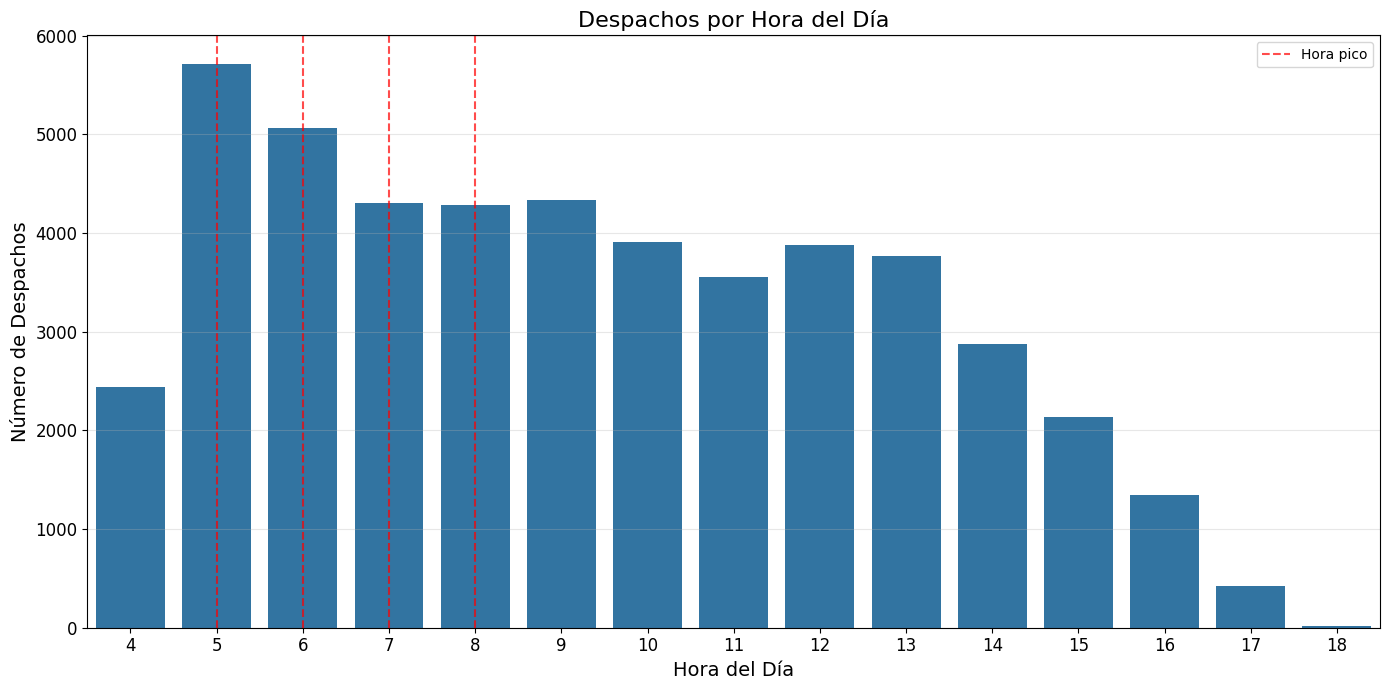

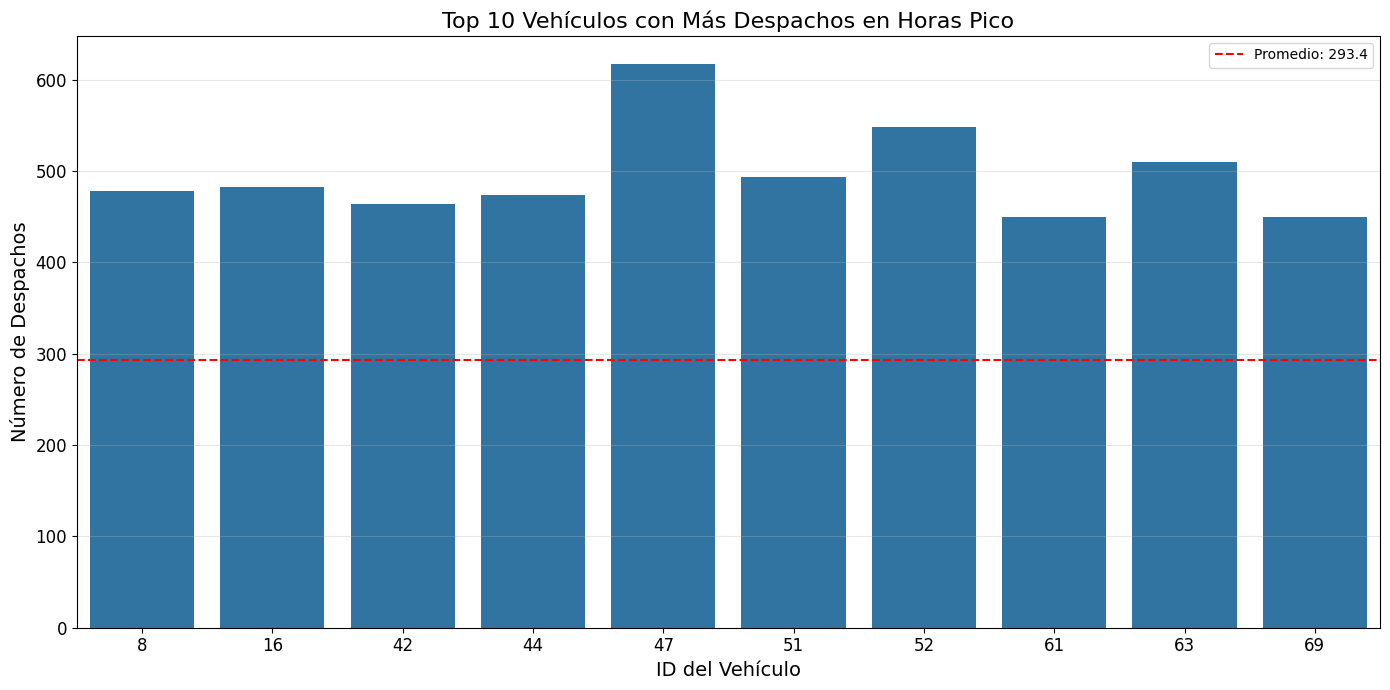

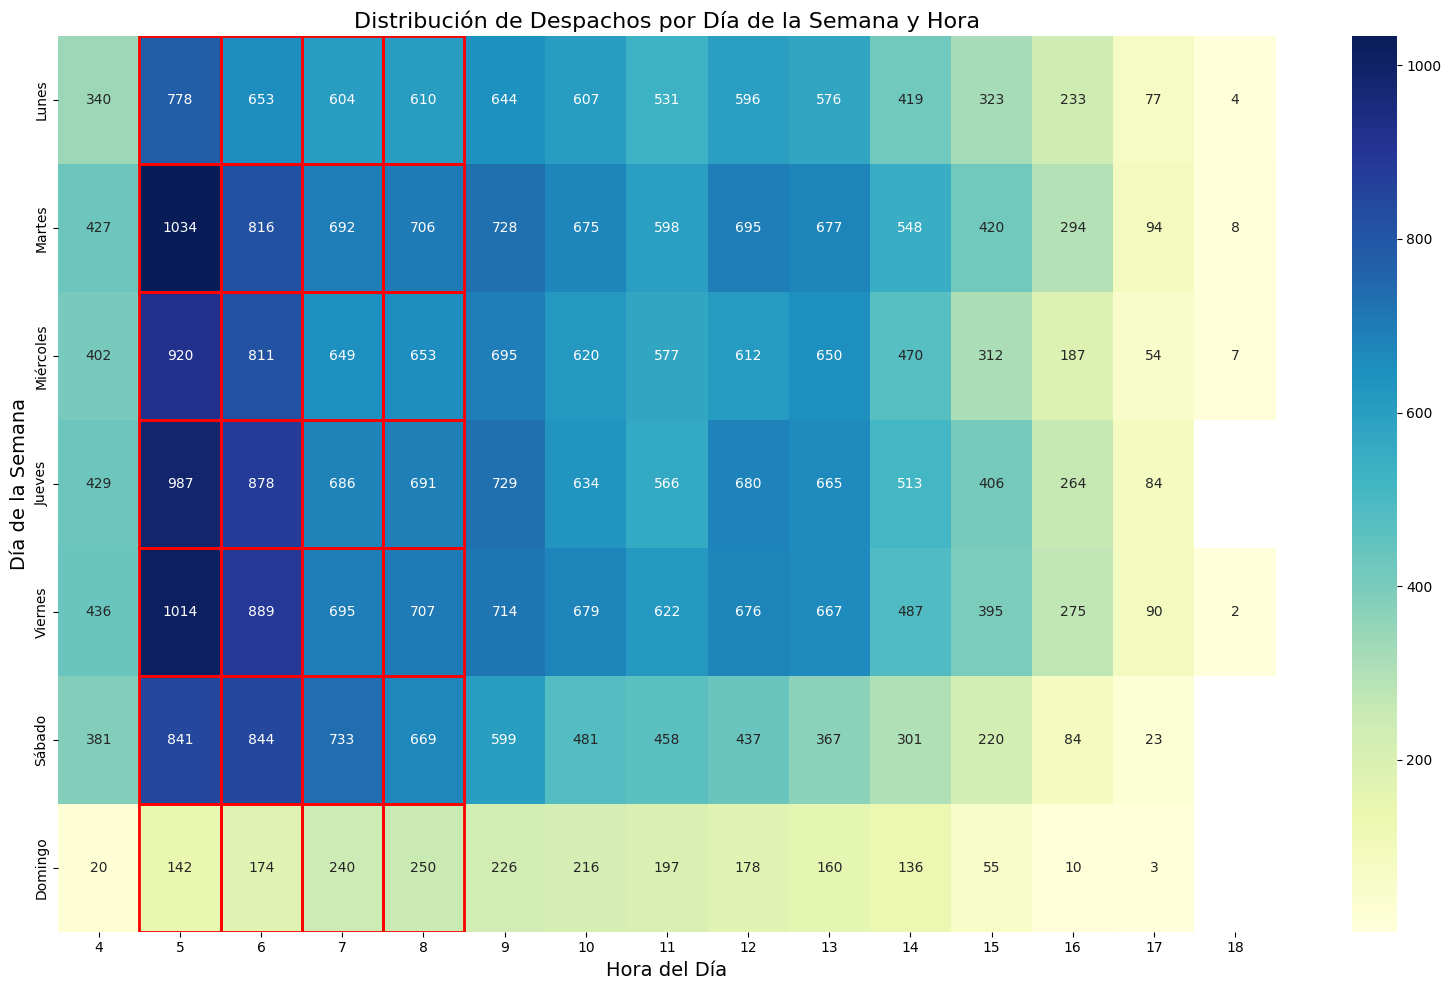

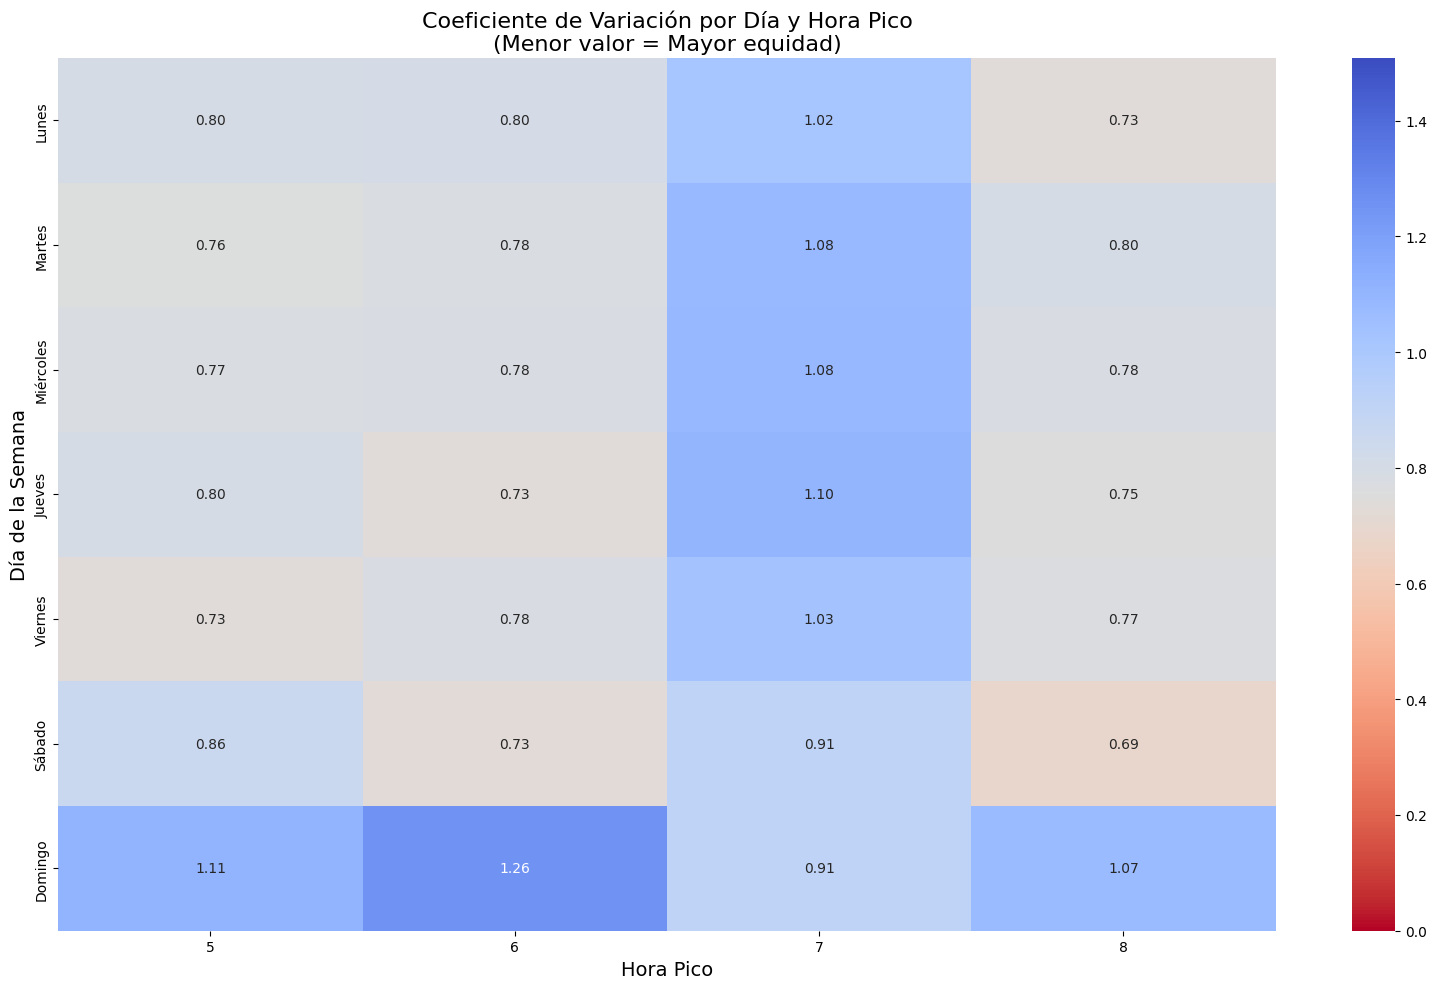

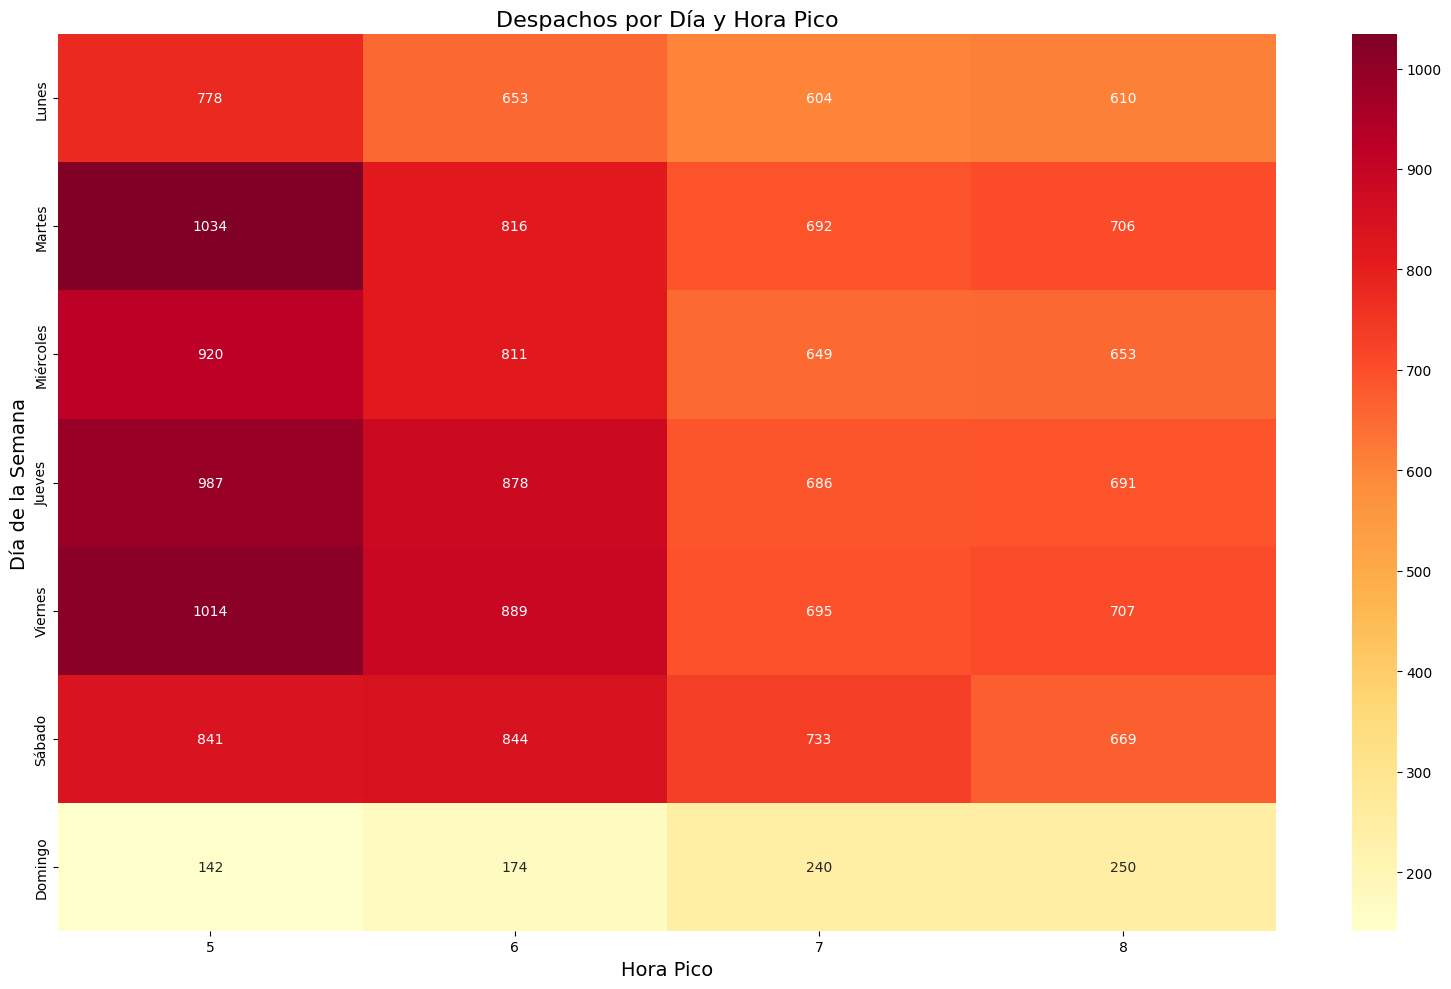

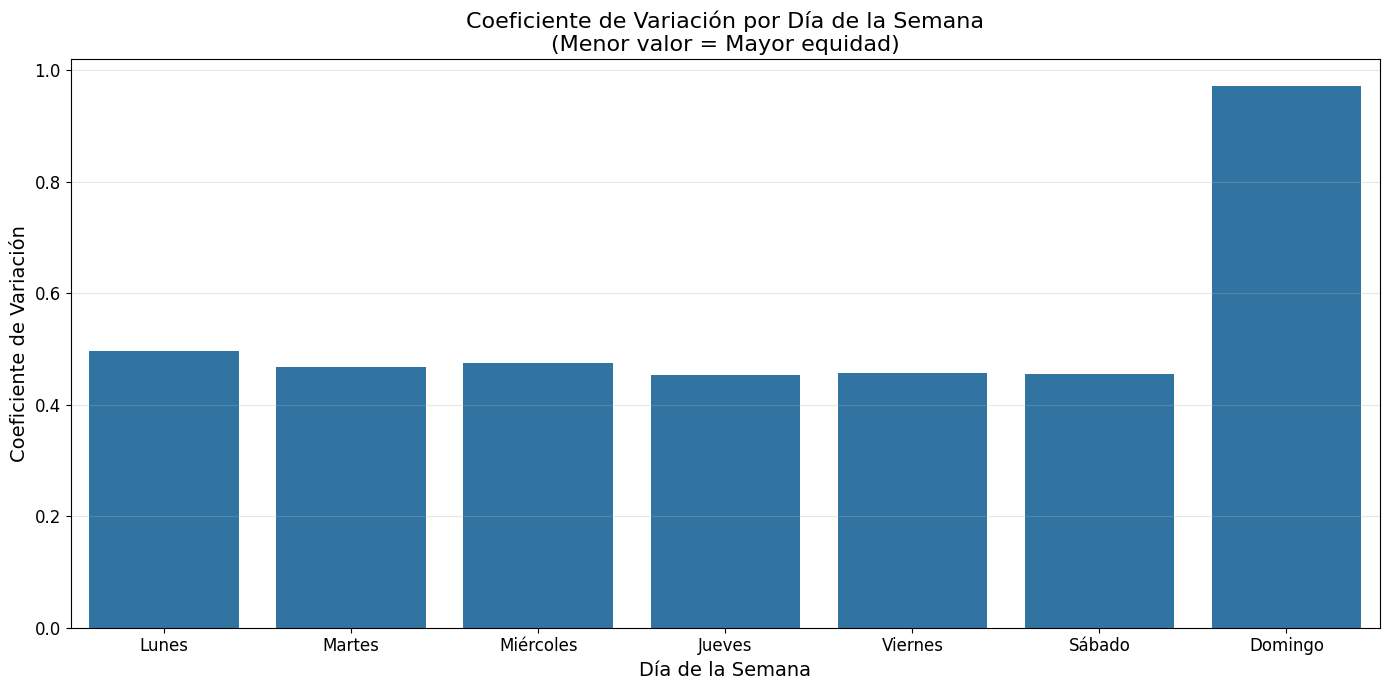

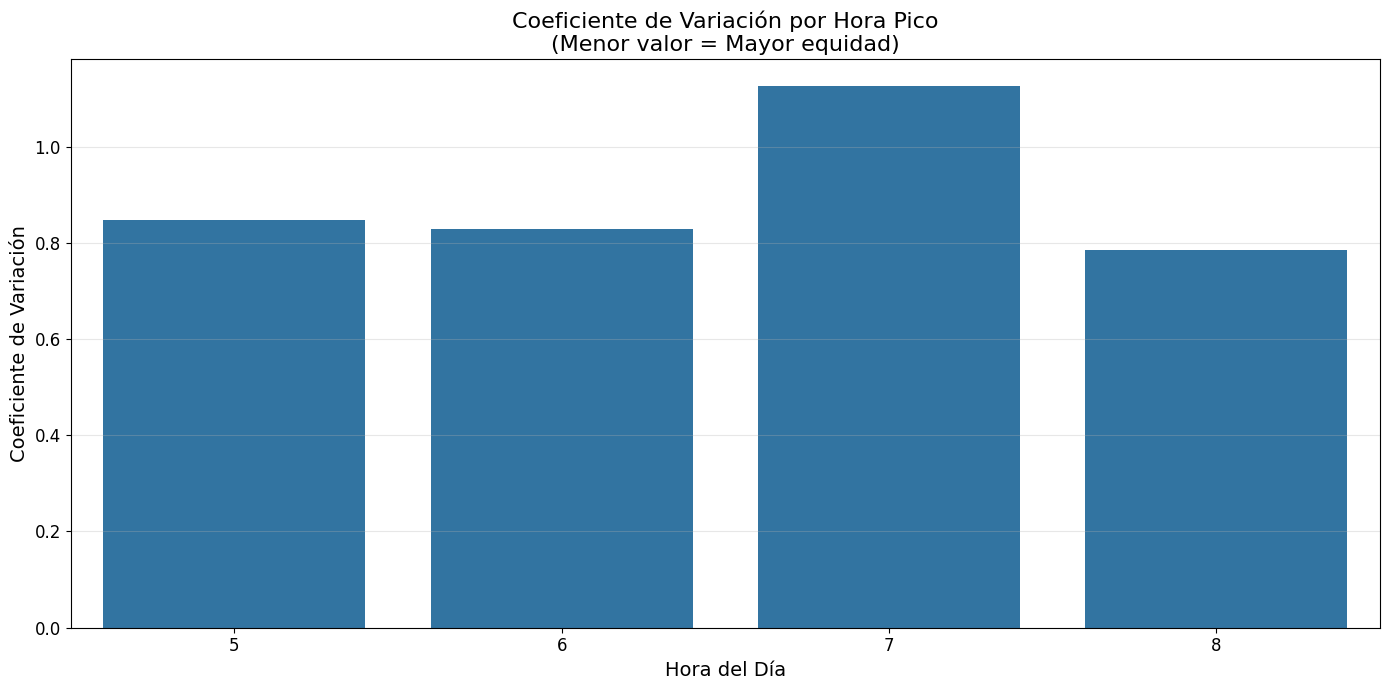


=== INFORME DE ASIGNACIÓN EQUITATIVA DE DESPACHOS EN HORAS PICO ===

Horas pico identificadas: [5, 6, 7, 8]
Total de vehículos analizados: 66
Promedio de despachos por vehículo en horas pico: 293.42
Desviación estándar: 137.86
Coeficiente de variación general: 0.4698

Asignación por día de la semana (CV - menor valor = mayor equidad):
  Lunes: 0.4967
  Martes: 0.4680
  Miércoles: 0.4753
  Jueves: 0.4533
  Viernes: 0.4569
  Sábado: 0.4554
  Domingo: 0.9716

Asignación por hora pico (CV - menor valor = mayor equidad):
  Hora 5: 0.8476
  Hora 6: 0.8284
  Hora 7: 1.1257
  Hora 8: 0.7858

Top 5 rutas con más despachos:
  Ruta 1: 23516 despachos
  Ruta 3: 23232 despachos
  Ruta 6: 756 despachos
  Ruta 5: 527 despachos

Se han generado las siguientes visualizaciones
1. Gráfico de línea: Cantidad de despachos por hora del día
2. Gráfico de línea: Cantidad de despachos por día de la semana y hora
3. Gráfico de línea: Cantidad de despachos por ruta y hora (Top 5 rutas)
4. Gráfico de línea: Cant

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import locale

# Intentar configurar la localización para español
try:
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')
    except:
        pass

# Cargar el archivo
df = pd.read_csv('datos_filtrados.csv', sep=';')

# Convertir HORA_INICIAL_REAL a datetime y extraer la hora
df['HORA_REAL'] = pd.to_datetime(df['HORA_INICIAL_REAL'], errors='coerce')
df['HORA_DIA'] = df['HORA_REAL'].dt.hour

# Orden correcto de los días de la semana
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_es = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
dias_dict = dict(zip(orden_dias, dias_es))

# Traducir los días de la semana a español
df['DIA_ES'] = df['DIA_SEMANA'].map(dias_dict)

# Agrupar por hora del día y contar pasajeros para identificar horas pico
pasajeros_por_hora = df.groupby('HORA_DIA').agg({
    'PASAJEROS': 'sum',
    'PK_INTERVALO_DESPACHO': 'count'  # Contar despachos por hora
}).reset_index()
pasajeros_por_hora.columns = ['HORA_DIA', 'TOTAL_PASAJEROS', 'TOTAL_DESPACHOS']
pasajeros_por_hora = pasajeros_por_hora.sort_values('HORA_DIA')  # Ordenar por hora

pasajeros_ordenados = pasajeros_por_hora.sort_values('TOTAL_PASAJEROS', ascending=False)
num_horas_pico = max(1, int(len(pasajeros_por_hora) * 0.33))
horas_pico_lista = pasajeros_ordenados.head(num_horas_pico)['HORA_DIA'].tolist()
horas_pico_lista = sorted(horas_pico_lista)  # Ordenar las horas pico

print(f"Las horas pico identificadas son: {horas_pico_lista}")

# Filtrar datos solo para horas pico
df_pico = df[df['HORA_DIA'].isin(horas_pico_lista)]

# Análisis de despachos por vehículo en horas pico
despachos_vehiculo = df_pico.groupby(['FK_VEHICULO']).size().reset_index(name='num_despachos')
despachos_vehiculo = despachos_vehiculo.sort_values('num_despachos', ascending=False)

# Top 10 vehículos con más despachos en horas pico
print("\nTop 10 vehículos con más despachos en horas pico:")
print(despachos_vehiculo.head(10))

# Análisis por día de la semana y hora (con orden correcto de días)
despachos_dia_hora = df.groupby(['DIA_ES', 'HORA_DIA']).agg({
    'FK_VEHICULO': 'count',  # Número de despachos
    'PASAJEROS': 'sum'      # Total de pasajeros
}).reset_index()

despachos_dia_hora.columns = ['DIA_SEMANA', 'HORA_DIA', 'NUM_DESPACHOS', 'TOTAL_PASAJEROS']

# Asegurar que los días estén en el orden correcto
despachos_dia_hora['orden_dia'] = despachos_dia_hora['DIA_SEMANA'].map(
    {dia: i for i, dia in enumerate(dias_es)}
)
despachos_dia_hora = despachos_dia_hora.sort_values(['orden_dia', 'HORA_DIA'])

# Análisis de despachos por hora del día (todas las horas)
despachos_por_hora = df.groupby('HORA_DIA').size().reset_index(name='NUM_DESPACHOS')
despachos_por_hora = despachos_por_hora.sort_values('HORA_DIA')

# Análisis de equidad en las horas pico por día de la semana
cv_dia_hora_pico = {}
for dia in orden_dias:
    dia_es = dias_dict[dia]
    cv_hora = {}
    for hora in horas_pico_lista:
        df_filtrado = df_pico[(df_pico['DIA_SEMANA'] == dia) & (df_pico['HORA_DIA'] == hora)]
        despachos_vehiculo_hora = df_filtrado.groupby('FK_VEHICULO').size()
        if len(despachos_vehiculo_hora) > 1:
            cv = despachos_vehiculo_hora.std() / despachos_vehiculo_hora.mean() if despachos_vehiculo_hora.mean() > 0 else 0
            cv_hora[hora] = cv
    cv_dia_hora_pico[dia_es] = cv_hora

# DataFrame para la visualización de CV por día y hora pico
cv_data = []
for dia, horas in cv_dia_hora_pico.items():
    for hora, cv in horas.items():
        cv_data.append({'DIA_SEMANA': dia, 'HORA_DIA': hora, 'CV': cv})

df_cv = pd.DataFrame(cv_data)
if not df_cv.empty:
    df_cv['orden_dia'] = df_cv['DIA_SEMANA'].map({dia: i for i, dia in enumerate(dias_es)})
    df_cv = df_cv.sort_values(['orden_dia', 'HORA_DIA'])

# Análisis de equidad en la distribución de despachos
despachos_por_vehiculo = df_pico.groupby('FK_VEHICULO').size()
cv_general = despachos_por_vehiculo.std() / despachos_por_vehiculo.mean() if despachos_por_vehiculo.mean() > 0 else 0

print(f"\nCoeficiente de variación general en la distribución de despachos: {cv_general:.4f}")
print(f"Un valor más cercano a 0 indica una distribución más equitativa.")

# Comparativa de despachos por hora pico y por día
despachos_hora_pico_dia = df_pico.groupby(['DIA_ES', 'HORA_DIA']).size().reset_index(name='NUM_DESPACHOS')
despachos_hora_pico_dia['orden_dia'] = despachos_hora_pico_dia['DIA_ES'].map({dia: i for i, dia in enumerate(dias_es)})
despachos_hora_pico_dia = despachos_hora_pico_dia.sort_values(['orden_dia', 'HORA_DIA'])

# Análisis de despachos por ruta y por hora
despachos_ruta_hora = df.groupby(['FK_RUTA', 'HORA_DIA']).size().reset_index(name='NUM_DESPACHOS')
despachos_ruta_hora = despachos_ruta_hora.sort_values(['FK_RUTA', 'HORA_DIA'])

# Top rutas con más despachos
top_rutas = df.groupby('FK_RUTA').size().reset_index(name='TOTAL_DESPACHOS')
top_rutas = top_rutas.sort_values('TOTAL_DESPACHOS', ascending=False)
top_5_rutas = top_rutas.head(5)['FK_RUTA'].tolist()

# Top 5 de rutas para graficar
despachos_top_rutas_hora = despachos_ruta_hora[despachos_ruta_hora['FK_RUTA'].isin(top_5_rutas)]

# Visualizaciones

# 1. Gráfico de línea - Despachos por hora del día
plt.figure(figsize=(14, 7))
sns.lineplot(x='HORA_DIA', y='NUM_DESPACHOS', data=despachos_por_hora, marker='o', linewidth=2.5)

# Horas pico destacadas
for hora in horas_pico_lista:
    plt.axvspan(hora-0.5, hora+0.5, alpha=0.2, color='red')

plt.title('Cantidad de Despachos por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Número de Despachos', fontsize=14)
plt.xticks(range(min(despachos_por_hora['HORA_DIA']), max(despachos_por_hora['HORA_DIA'])+1))
plt.grid(True, alpha=0.3)
plt.legend(['Despachos', 'Horas Pico'], loc='upper right')
plt.tight_layout()
plt.savefig('linea_despachos_hora.png')
plt.show()

# 2. Gráfico de línea - Despachos por día de la semana y hora del día
plt.figure(figsize=(15, 8))

for dia in dias_es:
    data_dia = despachos_dia_hora[despachos_dia_hora['DIA_SEMANA'] == dia]
    sns.lineplot(x='HORA_DIA', y='NUM_DESPACHOS', data=data_dia, marker='o', label=dia)

# Horas pico destacadas
for hora in horas_pico_lista:
    plt.axvspan(hora-0.5, hora+0.5, alpha=0.1, color='red')

plt.title('Cantidad de Despachos por Día de la Semana y Hora', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Número de Despachos', fontsize=14)
plt.xticks(range(min(despachos_dia_hora['HORA_DIA']), max(despachos_dia_hora['HORA_DIA'])+1))
plt.grid(True, alpha=0.3)
plt.legend(title='Día de la Semana')
plt.tight_layout()
plt.savefig('linea_despachos_dia_hora.png')
plt.show()

# 3. Gráfico de línea - Despachos por ruta y hora (top 5 rutas)
plt.figure(figsize=(15, 8))

for ruta in top_5_rutas:
    data_ruta = despachos_ruta_hora[despachos_ruta_hora['FK_RUTA'] == ruta]
    sns.lineplot(x='HORA_DIA', y='NUM_DESPACHOS', data=data_ruta, marker='o', label=f'Ruta {ruta}')

# Horas pico destacadas
for hora in horas_pico_lista:
    plt.axvspan(hora-0.5, hora+0.5, alpha=0.1, color='red')

plt.title('Cantidad de Despachos por Ruta y Hora (Top 5 Rutas)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Número de Despachos', fontsize=14)
plt.xticks(range(min(despachos_ruta_hora['HORA_DIA']), max(despachos_ruta_hora['HORA_DIA'])+1))
plt.grid(True, alpha=0.3)
plt.legend(title='Ruta')
plt.tight_layout()
plt.savefig('linea_despachos_ruta_hora.png')
plt.show()  # Para visualización en Colab

# 4. Gráfico de línea - Foco en las horas pico por día
plt.figure(figsize=(15, 8))

for dia in dias_es:
    data_dia_pico = despachos_hora_pico_dia[despachos_hora_pico_dia['DIA_ES'] == dia]
    sns.lineplot(x='HORA_DIA', y='NUM_DESPACHOS', data=data_dia_pico, marker='o', label=dia, linewidth=2.5)

plt.title('Cantidad de Despachos en Horas Pico por Día de la Semana', fontsize=16)
plt.xlabel('Hora Pico', fontsize=14)
plt.ylabel('Número de Despachos', fontsize=14)
plt.xticks(horas_pico_lista)
plt.grid(True, alpha=0.3)
plt.legend(title='Día de la Semana')
plt.tight_layout()
plt.savefig('linea_despachos_horas_pico.png')
plt.show()

# 5. Gráfico de barras - Pasajeros por hora del día
plt.figure(figsize=(14, 7))
sns.barplot(x='HORA_DIA', y='TOTAL_PASAJEROS', data=pasajeros_por_hora)
for i, hora in enumerate(horas_pico_lista):
    plt.axvline(x=pasajeros_por_hora['HORA_DIA'].tolist().index(hora),
                color='red', linestyle='--', alpha=0.7)
plt.title('Total de Pasajeros por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Total de Pasajeros', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('pasajeros_por_hora.png')
plt.show()

# 6. Gráfico de barras - Despachos por hora del día
plt.figure(figsize=(14, 7))
sns.barplot(x='HORA_DIA', y='NUM_DESPACHOS', data=despachos_por_hora)
for i, hora in enumerate(horas_pico_lista):
    plt.axvline(x=despachos_por_hora['HORA_DIA'].tolist().index(hora),
                color='red', linestyle='--', alpha=0.7, label='Hora pico' if i == 0 else "")
plt.title('Despachos por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Número de Despachos', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('despachos_por_hora.png')
plt.show()

# 7. Gráfico de barras - Top 10 vehículos con más despachos en horas pico
plt.figure(figsize=(14, 7))
top_vehiculos = despachos_vehiculo.head(10)
sns.barplot(x='FK_VEHICULO', y='num_despachos', data=top_vehiculos)
plt.axhline(y=despachos_vehiculo['num_despachos'].mean(), color='red', linestyle='--',
           label=f'Promedio: {despachos_vehiculo["num_despachos"].mean():.1f}')
plt.title('Top 10 Vehículos con Más Despachos en Horas Pico', fontsize=16)
plt.xlabel('ID del Vehículo', fontsize=14)
plt.ylabel('Número de Despachos', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('top_vehiculos.png')
plt.show()

# 8. Heatmap - Distribución de despachos por día de la semana y hora
plt.figure(figsize=(16, 10))
pivot_table = pd.pivot_table(despachos_dia_hora, values='NUM_DESPACHOS',
                            index='DIA_SEMANA', columns='HORA_DIA',
                            aggfunc='sum')

# Reordenar los días de la semana
pivot_table = pivot_table.reindex(dias_es)

# Crear una máscara para las horas pico
is_hora_pico = np.zeros(pivot_table.shape, dtype=bool)
for i, dia in enumerate(pivot_table.index):
    for j, hora in enumerate(pivot_table.columns):
        if hora in horas_pico_lista:
            is_hora_pico[i, j] = True

# Heatmap con un marco en las horas pico
ax = sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='g')

# Horas pico destacadas
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        if pivot_table.columns[j] in horas_pico_lista:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

plt.title('Distribución de Despachos por Día de la Semana y Hora', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Día de la Semana', fontsize=14)
plt.tight_layout()
plt.savefig('despachos_dia_hora.png')
plt.show()

# 9. Heatmap - Visualización de equidad (CV) por día y hora pico
if not df_cv.empty:
    plt.figure(figsize=(16, 10))
    pivot_cv = pd.pivot_table(df_cv, values='CV', index='DIA_SEMANA', columns='HORA_DIA')

    # Reordenar los días de la semana
    try:
        pivot_cv = pivot_cv.reindex(dias_es)
        ax = sns.heatmap(pivot_cv, annot=True, cmap='coolwarm_r', fmt='.2f',
                         vmin=0, vmax=min(2, pivot_cv.max().max() * 1.2))
        plt.title('Coeficiente de Variación por Día y Hora Pico\n(Menor valor = Mayor equidad)', fontsize=16)
        plt.xlabel('Hora Pico', fontsize=14)
        plt.ylabel('Día de la Semana', fontsize=14)
        plt.tight_layout()
        plt.savefig('equidad_dia_hora.png')
        plt.show()
    except:
        print("No se pudo crear el heatmap de CV por insuficiencia de datos en algunos días/horas")

# 10. Heatmap - Comparativa de despachos por hora pico y día
plt.figure(figsize=(16, 10))
pivot_pico = pd.pivot_table(despachos_hora_pico_dia, values='NUM_DESPACHOS',
                           index='DIA_ES', columns='HORA_DIA')

# Reordenar los días de la semana
pivot_pico = pivot_pico.reindex(dias_es)

# Filtrar solo horas pico
pivot_pico = pivot_pico.loc[:, horas_pico_lista]

ax = sns.heatmap(pivot_pico, annot=True, cmap='YlOrRd', fmt='g')
plt.title('Despachos por Día y Hora Pico', fontsize=16)
plt.xlabel('Hora Pico', fontsize=14)
plt.ylabel('Día de la Semana', fontsize=14)
plt.tight_layout()
plt.savefig('despachos_hora_pico_dia.png')
plt.show()

# 11. Gráfico de barras - Visualización de asignación equitativa mediante comparativa entre días
cv_por_dia = {}
for dia in orden_dias:
    dia_es = dias_dict[dia]
    df_dia = df_pico[df_pico['DIA_SEMANA'] == dia]
    if not df_dia.empty:
        despachos_vehiculo_dia = df_dia.groupby('FK_VEHICULO').size()
        if len(despachos_vehiculo_dia) > 1:
            cv_dia = despachos_vehiculo_dia.std() / despachos_vehiculo_dia.mean()
            cv_por_dia[dia_es] = cv_dia

plt.figure(figsize=(14, 7))
cv_df = pd.DataFrame(list(cv_por_dia.items()), columns=['Día', 'CV'])
cv_df['orden'] = cv_df['Día'].map({dia: i for i, dia in enumerate(dias_es)})
cv_df = cv_df.sort_values('orden')
sns.barplot(x='Día', y='CV', data=cv_df)
plt.title('Coeficiente de Variación por Día de la Semana\n(Menor valor = Mayor equidad)', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=14)
plt.ylabel('Coeficiente de Variación', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('equidad_por_dia.png')
plt.show()  # Para visualización en Colab

# 12. Visualización de asignación equitativa por hora pico
cv_por_hora = {}
for hora in horas_pico_lista:
    df_hora = df_pico[df_pico['HORA_DIA'] == hora]
    if not df_hora.empty:
        despachos_vehiculo_hora = df_hora.groupby('FK_VEHICULO').size()
        if len(despachos_vehiculo_hora) > 1:
            cv_hora = despachos_vehiculo_hora.std() / despachos_vehiculo_hora.mean()
            cv_por_hora[hora] = cv_hora

plt.figure(figsize=(14, 7))
cv_hora_df = pd.DataFrame(list(cv_por_hora.items()), columns=['Hora', 'CV'])
cv_hora_df = cv_hora_df.sort_values('Hora')
sns.barplot(x='Hora', y='CV', data=cv_hora_df)
plt.title('Coeficiente de Variación por Hora Pico\n(Menor valor = Mayor equidad)', fontsize=16)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Coeficiente de Variación', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('equidad_por_hora.png')
plt.show()  # Para visualización en Colab

# Resumen
print("\n=== INFORME DE ASIGNACIÓN EQUITATIVA DE DESPACHOS EN HORAS PICO ===")
print(f"\nHoras pico identificadas: {horas_pico_lista}")
print(f"Total de vehículos analizados: {len(despachos_por_vehiculo)}")
print(f"Promedio de despachos por vehículo en horas pico: {despachos_por_vehiculo.mean():.2f}")
print(f"Desviación estándar: {despachos_por_vehiculo.std():.2f}")
print(f"Coeficiente de variación general: {cv_general:.4f}")

print("\nAsignación por día de la semana (CV - menor valor = mayor equidad):")
for dia, cv in cv_por_dia.items():
    print(f"  {dia}: {cv:.4f}")

print("\nAsignación por hora pico (CV - menor valor = mayor equidad):")
for hora, cv in sorted(cv_por_hora.items()):
    print(f"  Hora {hora}: {cv:.4f}")

print("\nTop 5 rutas con más despachos:")
for i, ruta in enumerate(top_5_rutas):
    total_despachos = top_rutas[top_rutas['FK_RUTA']==ruta]['TOTAL_DESPACHOS'].values[0]
    print(f"  Ruta {ruta}: {total_despachos} despachos")

# Mostrar las imágenes generadas
print("\nSe han generado las siguientes visualizaciones")
print("1. Gráfico de línea: Cantidad de despachos por hora del día")
print("2. Gráfico de línea: Cantidad de despachos por día de la semana y hora")
print("3. Gráfico de línea: Cantidad de despachos por ruta y hora (Top 5 rutas)")
print("4. Gráfico de línea: Cantidad de despachos en horas pico por día de la semana")
print("5. Gráfico de barras: Pasajeros por hora del día ")
print("6. Gráfico de barras - Despachos por hora del día")
print("7. Gráfico de barras - Top 10 vehículos con más despachos en horas pico")
print("8. Heatmap - Distribución de despachos por día de la semana y hora")
print("9. Heatmap - Visualización de equidad (CV) por día y hora pico")
print("10. Heatmap - Comparativa de despachos por hora pico y día")
print("11. Gráfico de barras - Visualización de asignación equitativa mediante comparativa entre días")